# Chapter 3.6 Support Vector Machine - Examples

Here, we provide three example of SVM, and introduce the **sci-ki learn** package: https://scikit-learn.org/stable/modules/svm.html

Copyright: 

In [ ]:
# For compatibility with Python 2
from __future__ import print_function

# To load datasets
from sklearn import datasets
from sklearn.datasets import make_blobs

# To import the classifier (SVM classifier)
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# To measure accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

# To support plots
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# To increase quality of figures
plt.rcParams["figure.figsize"] = (20, 10)

# To display all the plots inline
%matplotlib inline 

# Basics
import numpy as np
import math
import cvxopt

# To import the scalers
from sklearn.preprocessing import MinMaxScaler

class DummyScaler:
    def fit(self, data):
        pass
    def transform(self, data):
        return data

def create_scaler_minmax():
    return MinMaxScaler()

## 1. A Simple Walk-through of the Whole Pipeline

Here we will build a SVM without using the sklearn SVC function, to show the math. Then we will also show the performance of the sklearn SVC function, to compare the results.

## 1.1 Build the entire math model step by step

First we define our SVM class, which contains functions that we will need later. 

Instead of using gradient descent to find the best fitting line as in the case of Linear Regression, we can directly solve for w and b using the Lagrangian.

To learn more about python classes and OOP: http://hplgit.github.io/primer.html/doc/pub/class/._class-readable001.html

In [ ]:
# be careful about the indentation in a long code block
class SVM(object):
  def fit(self, X, y):
    n_samples, n_features = X.shape

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
        K[i,j] = np.dot(X[i], X[j])
   
    P = cvxopt.matrix(np.outer(y, y) * K)  # P = X^T X 
    q = cvxopt.matrix(np.ones(n_samples) * -1) # q = -1 (1xN)
    A = cvxopt.matrix(y, (1, n_samples)) # A = y^T
    b = cvxopt.matrix(0.0) # b = 0 
    G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1)) # -1 (NxN)
    h = cvxopt.matrix(np.zeros(n_samples)) # 0 (1xN)
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    a = np.ravel(solution['x']) # Lagrange multipliers
    # Lagrange have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    self.a = a[sv]
    self.sv = X[sv]
    self.sv_y = y[sv]
    self.b = 0  # Intercept
    for n in range(len(self.a)):
      self.b += self.sv_y[n]
      self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
      self.b /= len(self.a)

    # Weights
    self.w = np.zeros(n_features)
    for n in range(len(self.a)):
      self.w += self.a[n] * self.sv_y[n] * self.sv[n]

  def project(self, X):
    return np.dot(X, self.w) + self.b

  def predict(self, X):
    return np.sign(self.project(X))

Next we generate some linearly separable data. 

We label the negative samples as -1 instead of 0. The package cvxopt expects the data to be in a specific format which is why we take an intermediate step.

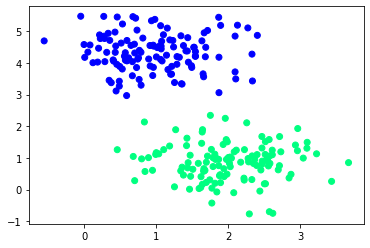

In [ ]:
X, y = make_blobs(n_samples = 250, centers = 2,
                  random_state = 0, cluster_std = 0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# plot the data we just generated
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'winter')

Then we can split the data into training and testing sets.

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# initiate a new object of the SVM class we just created, so it can use all the functions we made inside that SVM class
# svm is a model
svm = SVM()

# fit the training data to the model
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  4e-16  9e-15
 6: -4.0061e+00 -4.0104e+00  4e-03  1e-15  6e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  1e-15  4e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  7e-15
Optimal solution found.


Next, we plot the decision boundary and support vectors.

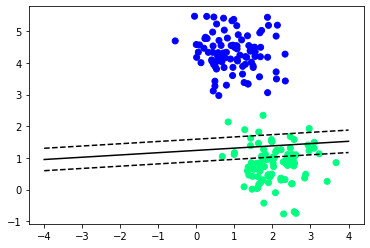

In [ ]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')

# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')

# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')

# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

Now we can use our model to predict the classes of the samples in the testing dataset.

The confusion matrix is used to evaluate the accuracy of our model.

In [ ]:
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 7, 27]])

## 1.2 Use Sci-ki Learn Functions

Here we build the SVM using the powerful functions from **sklearn**, without defining the mathematical details by ourselves.

In [ ]:
# LinearSVC is an existing class from sklearn, now we can just use it as well as all the functions within
svc = LinearSVC() 

# fit the training data to the model
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Plot the decision boundary and support vectors.

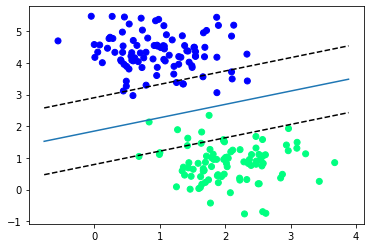

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

Same as in 1.1, we now use our model to predict the classes of the samples in the testing dataset.

The confusion matrix is used to evaluate the accuracy of our model.

In [ ]:
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])

## 2. A simple example of SVM using sklearn linearSVM

In [ ]:
# see more about the Iris dataset in section 3

#  Load data
iris = datasets.load_iris()
#  We can just consider the first two features
X = iris.data[:, :2] 
y = iris.target

C = 1.0 # SVM regularization parameters
svc = svm.SVC(kernel='linear', C=1).fit(X, y)

# Create a grid for visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Visualization of results
plt.subplot(1, 1, 1)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

## 3. SVM with different kernels with the Iris dataset

The **Iris flower data set or Fisher's Iris data set** is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper as an example of linear discriminant analysis. It is perhaps the best known database to be found in the pattern recognition literature.

More information can be found here: https://archive.ics.uci.edu/ml/datasets/iris

* Classes: 3 - 3 kinds of iris
* Samples per class: 50
* Samples total: 150
* Dimensionality: 4 - 4 parameters of the iris flowers
* Features: real, positive

In [ ]:
X, y = datasets.load_iris(return_X_y = True) 

# returns all the data as X, and their corresponding classes as y
# 4 columns in total, for the four parameters
# check the document for load_iris() function: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html

Trim the data to 2 variables/parameters and 2 classes, then scale the data

In [ ]:
X_trimmed = X[:, 1:3] # keep all the rows, column 1 and 2
X_trimmed = X_trimmed[y != 0, :] # delete the data in X that belongs to class 0
y_trimmed = y[y != 0] # delete all the class 0 tags in y

# scale the data for better performance
create_scaler = create_scaler_minmax
scaler = create_scaler()
scaler.fit(X_trimmed)
X_trimmed = scaler.transform(X_trimmed)

Plot the trimmed data with different colors

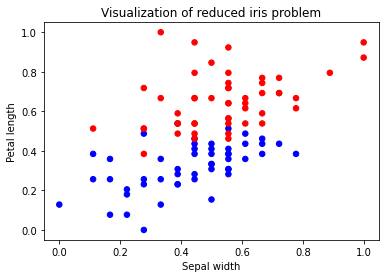

In [ ]:
plt.scatter(X_trimmed[:, 0], X_trimmed[:, 1], # these are the data of the 2 parameters picked
            c = y_trimmed, # y is the class of each dot, represented by blue and red
            s = 30, cmap = plt.cm.bwr)

plt.title('Visualization of reduced iris problem')
plt.xlabel('Sepal width')  # X_trimmed[:, 0], column 0
plt.ylabel('Petal length') # X_trimmed[:, 1], column 1
plt.show()

## 3.1 Build the Support Vector Machines Classifier

Here we will build multiple classifiers for this single dataset, in a single interactive plot, to show the difference causing by the choice of the kernel. SVM also has many other parameters, the choices of these parameters will lead to huge difference of the results.

A full list of parameters can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
# Here we use closure to store the related variables
def create_plot_svm_classification_kernels(_X, _y):
    X, y = _X, _y
    
    def plot_svc_kernel(C = 1, kernel = 'linear', expand = 3.1, intensity = 0.5):
        # kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
        
        # build the model here, clf is the model
        if kernel.startswith('poly'):
            clf = SVC(kernel = 'poly', C = C, gamma = 'auto', degree = int(kernel[4:]))
            # degree, int, default=3, degree of the polynomial kernel function (‘poly’) 
            # Ignored by all other kernels. That's why the poly kernel is picked out here
    
        else:
            clf = SVC(kernel = kernel, C = C, gamma = 'auto')
            # gamma{‘scale’, ‘auto’} or float, default=’scale’, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
            # other parameters take default value
        
        # fit the iris training data to the model we just built
        # the modeling is all done
        clf.fit(X, y)
    
    
        # plot the result (both the training data and the classifier)
        # since we are going to present different kernel, this plotting program is complex, just for the teaching purpose
        # under normal settings, we only need to plot a single kernel
        fig, ax = plt.subplots()
        ax.plot((np.min(X[:, 0]) - expand, np.max(X[:, 0]) + expand), 
                (np.min(X[:, 1]) - expand, np.max(X[:, 1]) + expand), alpha=0.0)
        
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        xx = np.linspace(xlim[0], xlim[1], 400)
        yy = np.linspace(ylim[0], ylim[1], 200)
        
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = clf.decision_function(xy).reshape(XX.shape)
        v = max(-np.min(Z), np.max(Z))
        cf = ax.contourf(XX, YY, Z, 200, cmap='coolwarm', 
                         norm = mpl.colors.Normalize(vmin=-v, vmax=v), alpha=intensity)
        
        ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.bwr)
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                   linestyles=['--', '-', '--'], linewidths=[2, 5, 2])
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        plt.xlabel('Sepal width')
        plt.ylabel('Petal length')
        plt.title('Support Vector Machines Classifier: C=%s, %s kernel.' % (str(C), kernel))
        plt.show()
        
    return plot_svc_kernel

Build an interactive diagram with widgets, only for teaching purpose.

In [ ]:
kernels = ['linear'] + ['poly'+str(x) for x in range(1, 9)] + ['rbf']
С_widget = widgets.FloatLogSlider(
    value=1,
    base=10,
    min=-4,
    max=4,
    step=0.5,
    continuous_update=False,
    description='C')
expand_widget = widgets.FloatSlider(
    value=3.1,
    min=0,
    max=10,
    step=0.1,
    continuous_update=False,
    description='expand:')
intensity_widget = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=0.9,
    step=0.1,
    continuous_update=False,
    description='contour intensity:')

# Call the function we just made
interact(create_plot_svm_classification_kernels(X_trimmed, y_trimmed), 
         C = С_widget, kernel = kernels, expand = expand_widget, intensity = intensity_widget)

interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='C', min=-4.0, step=0.5),…

<function __main__.create_plot_svm_classification_kernels.<locals>.plot_svc_kernel>

**NOTE: To support interactive plots in jupyter lab, run these in command line:**

1. To install the nodejs package with conda run one of the following, make sure the version is above 12.0.0

conda install -c conda-forge nodejs 

conda install -c conda-forge/label/gcc7 nodejs 

conda install -c conda-forge/label/cf201901 nodejs 

conda install -c conda-forge/label/cf202003 nodejs

reference: https://anaconda.org/conda-forge/nodejs

2. This line may take a while to finish running, do not interrupt:

jupyter labextension install @jupyter-widgets/jupyterlab-manager